In [1]:
!pip install geopandas rasterio contextily pulp shapely

In [54]:
import sys, os

# ensure Python can see your MILP folder
sys.path.append(os.path.abspath("../"))  # one level up from your notebook

# now import the function
import MILP.distance_optimizer
import importlib
importlib.reload(MILP.distance_optimizer)  # reloads updated .py file
from MILP.distance_optimizer import optimize_shade_placement


import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as cx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pulp import *


Index(['OBJECTID', 'stop_id', 'route_count', 'route_stop', 'lat', 'lon',
       'geometry', 'heat_layer', 'index_right', 'socioeconomic_layer'],
      dtype='object')
n:  222  p:  94
dist_stats:  Candidate distances stats (upper tri) — min: 2.47 m, max: 7831.23 m, mean: 2477.40 m, median: 2372.62 m
 
public_stats:  Public distances stats — min: 32.40 m, max: 8537.86 m, mean: 2785.50 m, median: 2655.74 m

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/urvibhuwania/miniconda3/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/wl/c3pz93w50hz8v01l8clvl_qc0000gn/T/9169030c78a74bfcb3599a936c54d627-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/wl/c3pz93w50hz8v01l8clvl_qc0000gn/T/9169030c78a74bfcb3599a936c54d627-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 73599 COLUMNS
At line 295267 RHS
At line 368862 BOUNDS
At line 393616 ENDATA
Problem 

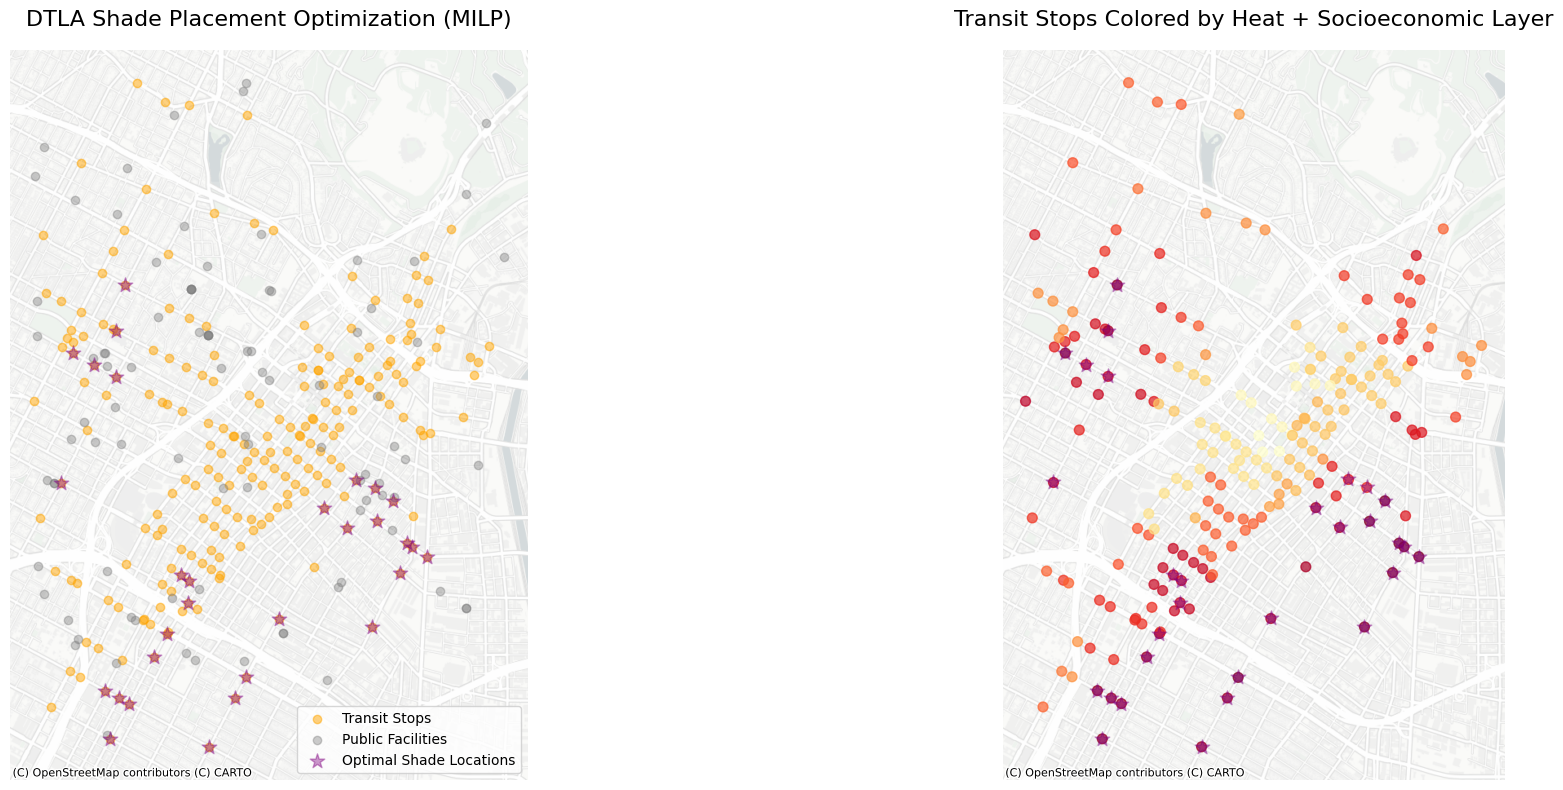

In [61]:
# --- Load DTLA data ---
bus_stops = gpd.read_file("../../461/data/bus_stops.geojson").to_crs(3857)
major_transit_stops_dtla = gpd.read_file("../../data/preprocessed/la_major_transit_stops_dtla.geojson").to_crs(3857)
schools_dtla = gpd.read_file("../../data/preprocessed/la_schools_dtla.geojson").to_crs(3857)
hospitals_dtla = gpd.read_file("../../data/preprocessed/la_hospitals_clinics_dtla.geojson").to_crs(3857)
food_dtla = gpd.read_file("../../data/preprocessed/la_food_assistance_dtla.geojson").to_crs(3857)
ucla_shade_heat = gpd.read_file("../../data/layers/heat_layer.geojson").to_crs(3857)
ucla_shade_socio = gpd.read_file("../../data/layers/socioeconomic_layer.geojson").to_crs(3857)

# --- Combine all public service facilities ---
public_points = gpd.GeoDataFrame(pd.concat(
    [schools_dtla[['geometry']], hospitals_dtla[['geometry']], food_dtla[['geometry']]],
    ignore_index=True), crs=schools_dtla.crs)

# --- Combine heat and shade layers with bus stops ---
processed_shade_stops = gpd.sjoin(major_transit_stops_dtla, ucla_shade_heat, how = 'left')
processed_shade_stops = processed_shade_stops.drop(columns=['index_right'])
processed_shade_stops = gpd.sjoin(processed_shade_stops, ucla_shade_socio, how = 'left')
print(processed_shade_stops.columns)

# --- Add together heat and socioeconomic layers to visualize point priority by these 2 objectives
processed_shade_stops['heat_socio_layer'] = (
    processed_shade_stops['heat_layer'] + processed_shade_stops['socioeconomic_layer']
)

# --- Run the MILP optimizer ---
optimized_shades = optimize_shade_placement(
    candidate_points=processed_shade_stops,
    public_points=public_points,
    max_shades=30,
    use_spacing=True,
    use_public=True,
    use_heat=True,
    use_socioeconomic=True,
)

print(f"Selected {len(optimized_shades)} optimal shade sites.")

# --- Visualize ---
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# Plot the first graph visualizing optimal shade locations against proximity to public service buildings
major_transit_stops_dtla.plot(ax=axes[0], color='orange', label='Transit Stops', alpha=0.5)
public_points.plot(ax=axes[0], color='gray', label='Public Facilities', alpha=0.4)
optimized_shades.plot(ax=axes[0], color='purple', marker='*', markersize=120, alpha = 0.4, label='Optimal Shade Locations')

cx.add_basemap(axes[0], source=cx.providers.CartoDB.PositronNoLabels)
axes[0].legend()
axes[0].set_title("DTLA Shade Placement Optimization (MILP)", fontsize=16)
axes[0].set_axis_off()

# Plot the second graph visualizing heat and socioeconomic priority layers
processed_shade_stops.plot(
    ax=axes[1],
    cmap = 'YlOrRd',
    column="heat_socio_layer",
    markersize=50,
    alpha=0.7
)
optimized_shades.plot(ax=axes[1], color='purple', marker='*', markersize=120, alpha=0.4, label='Optimal Shade Locations')
cx.add_basemap(axes[1], source=cx.providers.CartoDB.PositronNoLabels)
axes[1].set_title("Transit Stops Colored by Heat + Socioeconomic Layer", fontsize=16)
axes[1].set_axis_off()

plt.tight_layout()
plt.show()
